/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1359: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


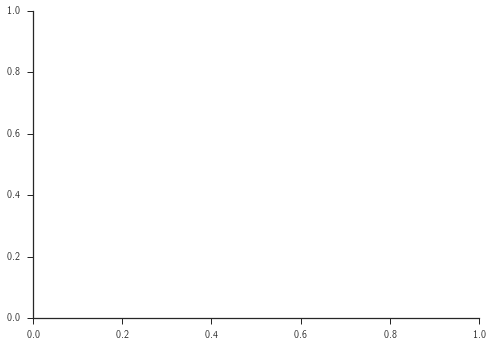

In [1]:
%matplotlib inline
import sys
sys.path.append('../simrest_validation/')
sys.path.append('/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
sys.path.append('../INM6/Tasks')
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import imp
from networkunit.models import cortical_microcircuit_data
from networkunit.scores import ks_distance, best_effect_size
from networkunit.tests import covariance_test, model2model_test
from viziphant.plots.rasterplot import rasterplot
import validation.dist as dist
import validation.matrix as matstat
from elephant.statistics import mean_firing_rate, cv, isi
import seaborn as sns
from quantities import Hz, ms
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())
rc('text', usetex=True)
font_size = 24
text_size = 26
figsize=(8,6)
img_path = '/home/robin/Sciebo/Poster/HBPSummit/images/'

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

#### Load functions for validation tools and visualization

In [3]:
def fontsize(ax, size):
    for item in ([ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(size)
    for item in (ax.get_xticklabels()+ ax.get_yticklabels()):
        item.set_fontsize(size-4)
    return None

#### Load spiketrains from simulation

In [ ]:
layer = 'spikes_L4E'

path = './sim_data/'

NEST = cortical_microcircuit_data(file_path=path + 'NEST_data/' + layer + '.h5',
                                  color='#FF6634',
                                  name='NEST Data Layer 4 exc')

SPINNAKER = cortical_microcircuit_data(file_path=path + 'SpiNNaker_data/' + layer + '.h5',
                                       color='#1B6145',
                                       name='SpiNNaker Data Layer 4 exc')
len(NEST.spiketrains)

100

#### Rasterplots

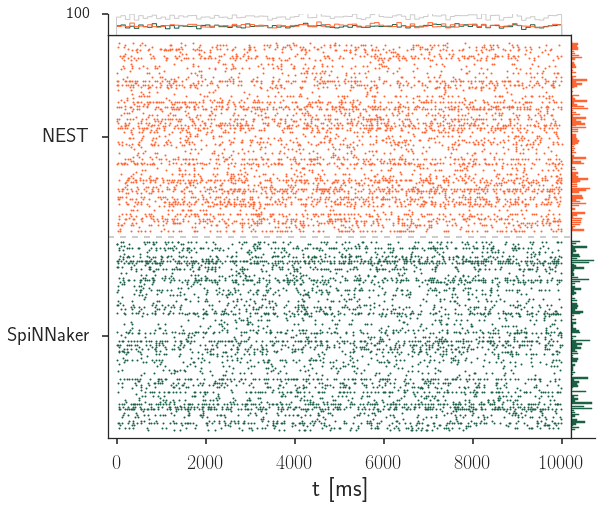

In [21]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()

palette = [SPINNAKER.params['color'], NEST.params['color']]

ax, axx, axy = rasterplot([SPINNAKER.spiketrains, NEST._align_to_zero(NEST.spiketrains)], ax=ax, 
                          palette=palette, 
                          context='poster', 
                          groupingdepth=1, spacing=5, labelkey=0, histscale=0.05)
ax.set_yticklabels(['SpiNNaker','NEST'])
# axy.set_xticklabels('')

fontsize(ax, font_size)
plt.savefig(img_path + 'rasterplot_stochastic.eps')

### KS Covariance Test

In [6]:
class ks_cov_test_2msbins_100sample(covariance_test, model2model_test):
    score_type = ks_distance
    params = {'max_subsamplesize': 100,
              'align_to_0' : True,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms,}

In [7]:
ks_cov_spinn_test = ks_cov_test_2msbins_100sample(observation=SPINNAKER,
                                                  name='KS Covariance SpiNNaker Test')

In [8]:
score = ks_cov_spinn_test.judge(model=NEST)

score.summarize()

=== Model NEST Data Layer 4 exc achieved score 

Kolmogorov-Smirnov-Distance
	datasize: 4950 	 4950
	D_KS = 0.061 	 p value = 0.000

 on test 'KS Covariance SpiNNaker Test'. ===


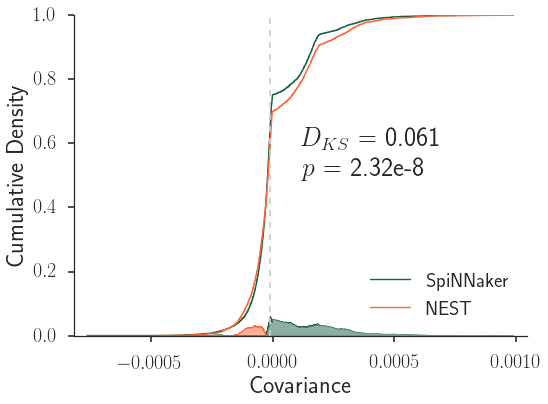

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

ks_cov_spinn_test.visualize_score(model=NEST, ax=ax, palette=palette, lw=1.4)

ax.text(.5, .5, r'$D_{KS}$ = ' + '{:.3f}\n'.format(score.score) 
                    + r'$p$ = ' + '{}'.format(dist.to_precision(score.pvalue,3)), 
                    fontsize=text_size, transform=ax.transAxes)
ax.legend(['SpiNNaker', 'NEST'], loc=4, fontsize=font_size-4)
ax.set_ylabel('Cumulative Density');

fontsize(ax, font_size)
fig.tight_layout()
sns.despine()

### Effect Size Test

In [10]:
class best_cov_test_2msbins_100sample(covariance_test, model2model_test):
    score_type = best_effect_size
    params = {'max_subsamplesize': 100,
              'align_to_0' : True,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms,
              'mcmc_iter' : 110000,
              'mcmc_burn' : 10000}

In [11]:
es_cov_spinn_test = best_cov_test_2msbins_100sample(observation=SPINNAKER,
                                                    name='Effect Size Covariance SpiNNaker Test')

In [12]:
score = es_cov_spinn_test.judge(model=NEST)

score.summarize()

/usr/local/lib/python2.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 110000 of 110000 complete in 696.3 sec=== Model NEST Data Layer 4 exc achieved score 

Baysian Estimation Effect Size
	datasize: 4950 	 4950
	Iterations: 110000 	 Burn: 10000
	Effect Size = -0.086 	 HDI = (-0.125, -0.044)

 on test 'Effect Size Covariance SpiNNaker Test'. ===


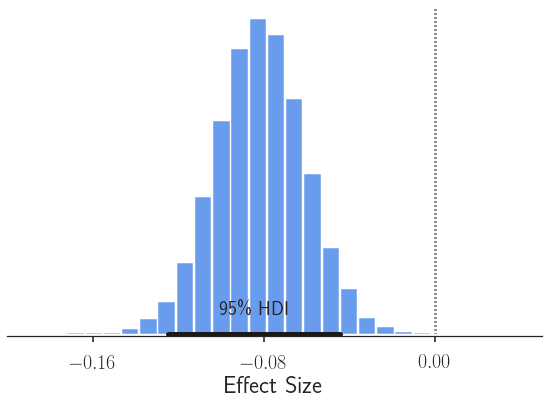

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

es_cov_spinn_test.visualize_score(model=NEST, ax=ax)

fontsize(ax, font_size)
fig.tight_layout()
sns.despine()